In [1]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapterFull

[2023-11-10 10:44:18,479] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/image_encoder/"
ip_ckpt = "models/ip-adapter-full-face_sd15.bin"
device = "cuda"

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [4]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
# load ip-adapter
# we use 256 patch tokens and 1 cls token
ip_model = IPAdapterFull(pipe, image_encoder_path, ip_ckpt, device, num_tokens=257)

## Best practices
- You should use a cropped face image, segment the face, and fill the background with pure white (255, 255, 255)- Select a proper weight (scale), 0.7 can achieve good results in most casese

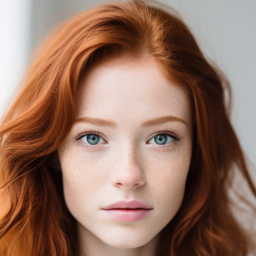

In [6]:
# read image prompt
image = Image.open("assets/images/ai_face2.png")
image.resize((256, 256))

  0%|          | 0/50 [00:00<?, ?it/s]

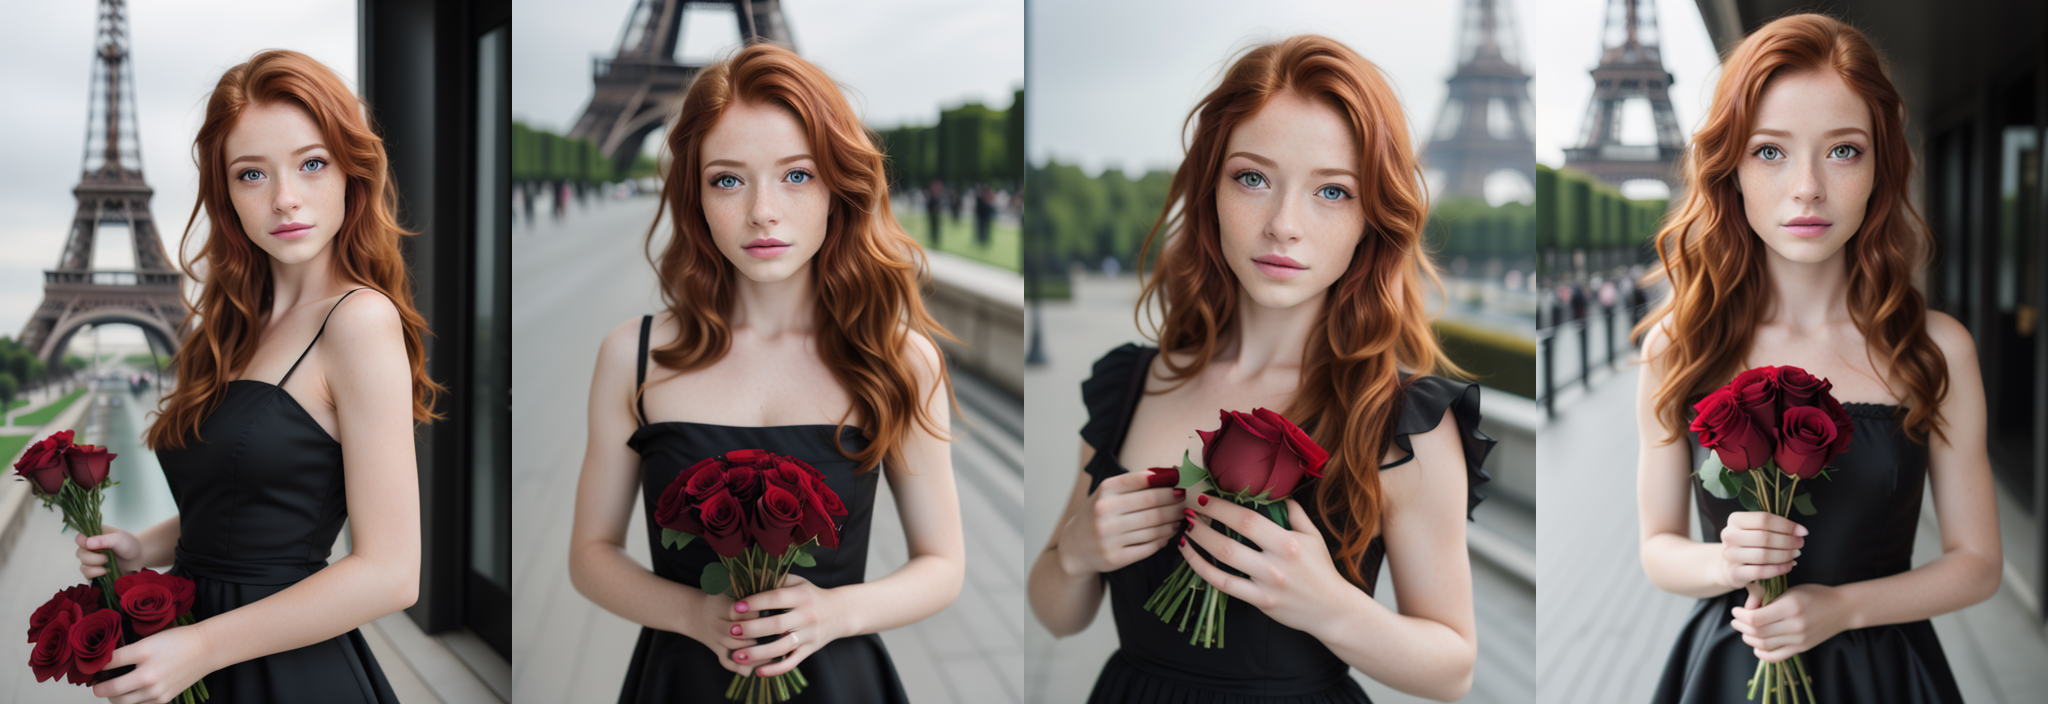

In [7]:
# use face as image prompt
images = ip_model.generate(
    pil_image=image, num_samples=4, prompt="A photo of a girl wearing a black dress, holding red roses in hand, upper body, behind is the Eiffel Tower",
    scale=0.7, width=512, height=704, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

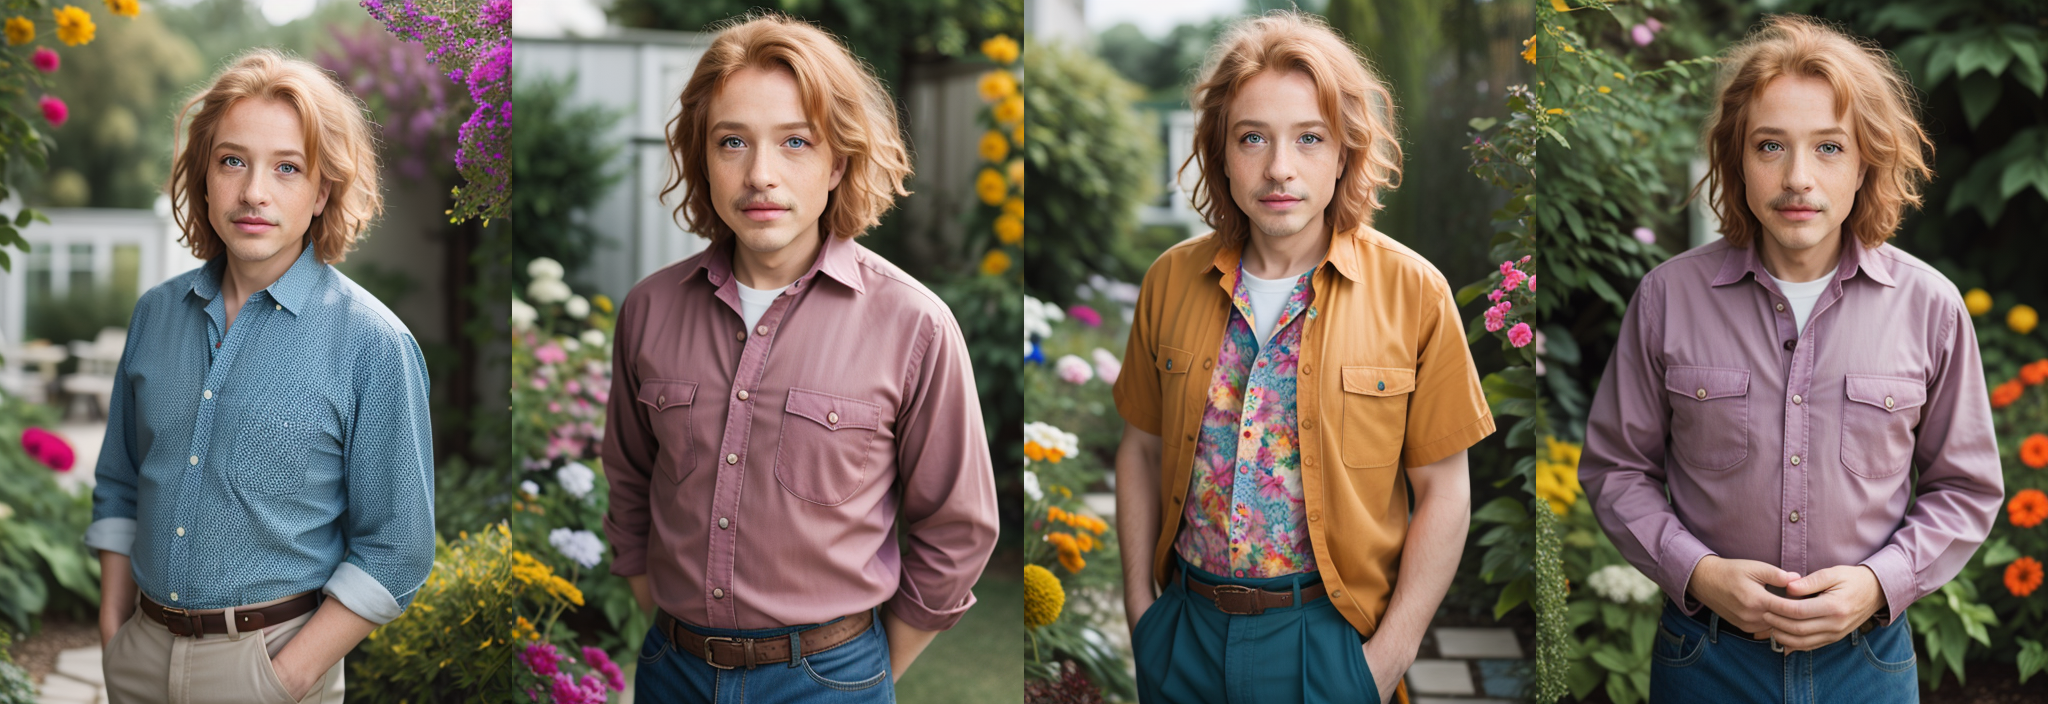

In [8]:
# Use a lower scale to mix faces
images = ip_model.generate(
    pil_image=image, num_samples=4, prompt="photo of Einstein wearing colorful casual shirt in a garden",
    scale=0.4, width=512, height=704, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

In [9]:
# Change to a anime model
del pipe, ip_model
torch.cuda.empty_cache()
base_model_path = "dreamlike-art/dreamlike-anime-1.0/"
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
# load ip-adapter
ip_model = IPAdapterFull(pipe, image_encoder_path, ip_ckpt, device, num_tokens=257)

  0%|          | 0/50 [00:00<?, ?it/s]

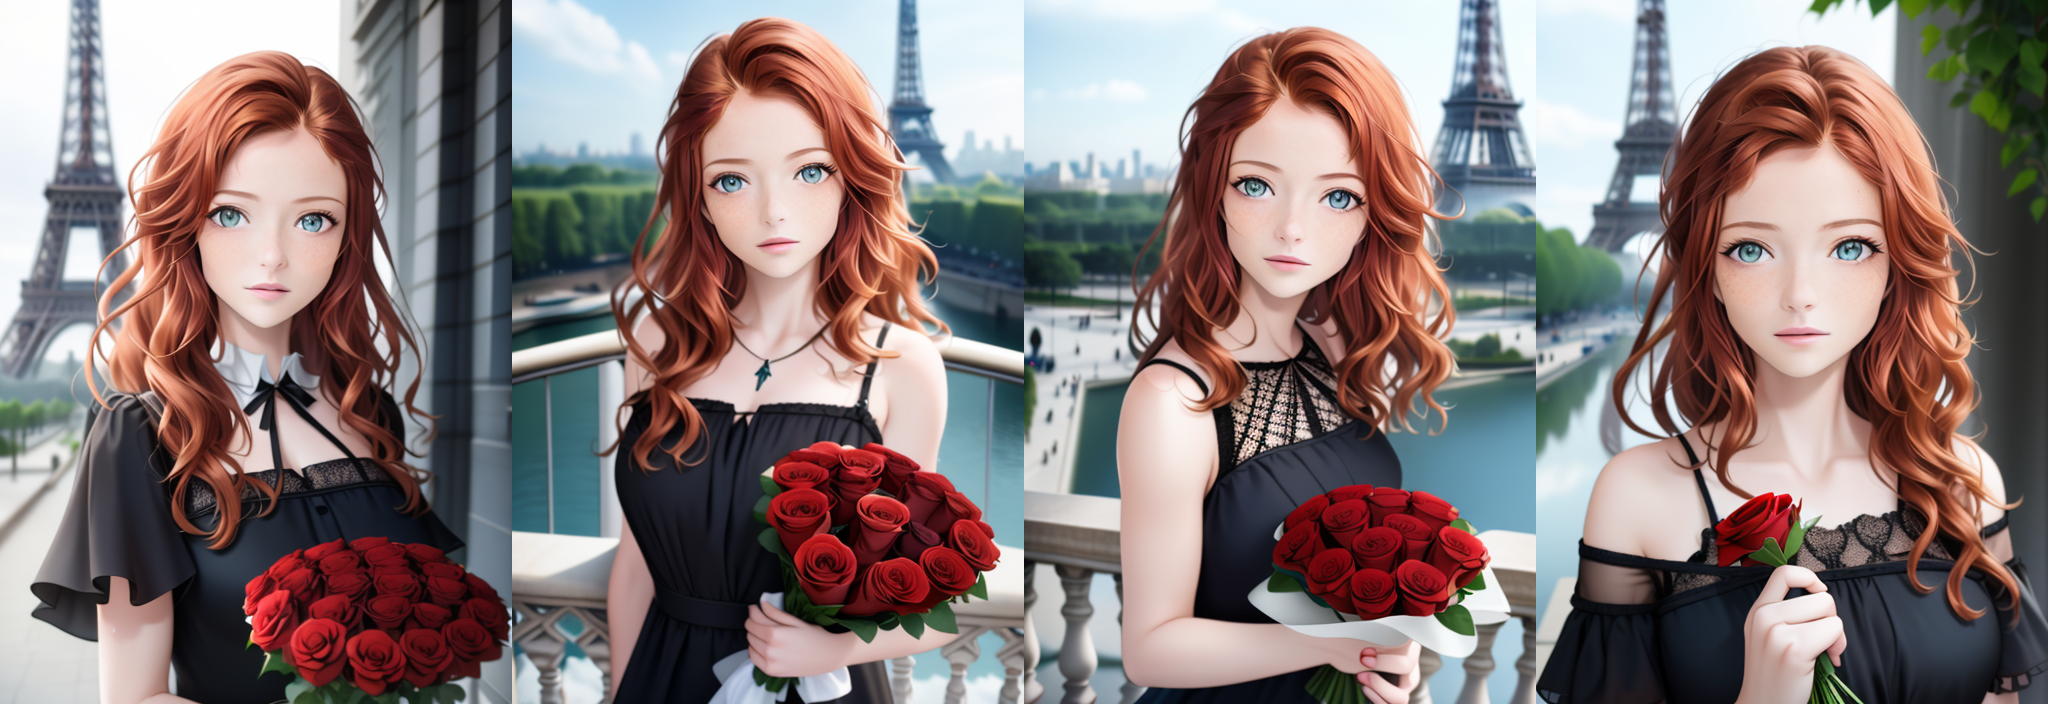

In [12]:
# use face as image prompt
images = ip_model.generate(
    pil_image=image, num_samples=4, prompt="A photo of a girl wearing a black dress, holding red roses in hand, upper body, behind is the Eiffel Tower",
    scale=0.6, width=512, height=704, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid